# Exploratory Analysis of Currency Exchange Rates - USD vs Other Countries

In this Python notebook, we'll be investigating the strength of the US Dollar against other countries over the last 6 election cyles (24 years) to understand how the exchange rates change before and after Election Day in a 30-day window. We'll explore the volatility of the currencies during this wind The currencies of our focused analysis are: Euro (EUR), Japananese Yen (JPY), and the Chinese Yuan (CNY). 

All of our data will be pulled from Federal Reserve at [https://www.federalreserve.gov/](https://www.federalreserve.gov/).

In [32]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

# Step 1: Data Prep

## Let's collect daily exchange rate data for the currencies of interest
Source: [https://www.federalreserve.gov/releases/h10/hist/default.htm](https://www.federalreserve.gov/releases/h10/hist/default.htm)

Our method is to save the raw html file locally and use the read_html() function to read the tables. There will be an html file for each country in the 'Resources' folder. 

In [33]:
# list of all countries by their currency abbreviation 
currencies = ['CNY', 'JPY', 'EUR']

# Past 8 election dates
election_dates = pd.to_datetime(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08', '2020-11-03', '2024-11-05'])
print(election_dates)

DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)


In [34]:
# All url's stored as variables
china_url = 'Resources/FRB_daily_china.html'
japan_url = 'Resources/FRB_daily_japan.html'
euro_url = 'Resources/FRB_daily_euro.html'


# Read the html file into the tables variable
tables_china_daily_xchange = pd.read_html(china_url)
tables_japan_daily_xchange = pd.read_html(japan_url)
tables_euro_daily_xchange = pd.read_html(euro_url)

# Let's check how many tables we extracted
print(f'There are {len(tables_china_daily_xchange)} table(s) extracted from the China exchanges rates url.')
print(f'There are {len(tables_japan_daily_xchange)} table(s) extracted from the Japan exchanges rates url.')
print(f'There are {len(tables_euro_daily_xchange)} table(s) extracted from the Euro exchanges rates url.')

# Create the data frames for all of our exchange rates 
df_china_daily = tables_china_daily_xchange[0]
df_japan_daily = tables_japan_daily_xchange[0]
df_euro_daily = tables_euro_daily_xchange[0]

# Preview our df
display(df_china_daily)
display(df_japan_daily)
display(df_euro_daily)

There are 1 table(s) extracted from the China exchanges rates url.
There are 1 table(s) extracted from the Japan exchanges rates url.
There are 1 table(s) extracted from the Euro exchanges rates url.


,Date,Rate
0,3-JAN-00,8.2798
1,4-JAN-00,8.2799
2,5-JAN-00,8.2798
3,6-JAN-00,8.2797
4,7-JAN-00,8.2794
...,...,...
6530,13-JAN-25,7.3319
6531,14-JAN-25,7.3311
6532,15-JAN-25,7.3304
6533,16-JAN-25,7.3316


,Date,Rate
0,3-JAN-00,101.7000
1,4-JAN-00,103.0900
2,5-JAN-00,103.7700
3,6-JAN-00,105.1900
4,7-JAN-00,105.1700
...,...,...
6530,13-JAN-25,157.5100
6531,14-JAN-25,157.9500
6532,15-JAN-25,156.6000
6533,16-JAN-25,155.4400


,Date,Rate
0,3-JAN-00,1.0155
1,4-JAN-00,1.0309
2,5-JAN-00,1.0335
3,6-JAN-00,1.0324
4,7-JAN-00,1.0294
...,...,...
6535,20-JAN-25,ND
6536,21-JAN-25,1.0423
6537,22-JAN-25,1.0420
6538,23-JAN-25,1.0420


In [35]:
# Let's rename the 'Rate' column to their respective their country
df_china_daily.rename(columns={'Rate': 'CNY'}, inplace=True)
df_japan_daily.rename(columns={'Rate': 'JPY'}, inplace=True)
df_euro_daily.rename(columns={'Rate': 'EUR'}, inplace=True)


# Preview each dataframe to confirm the addition of the column
display(df_china_daily)
display(df_japan_daily)
display(df_euro_daily)

,Date,CNY
0,3-JAN-00,8.2798
1,4-JAN-00,8.2799
2,5-JAN-00,8.2798
3,6-JAN-00,8.2797
4,7-JAN-00,8.2794
...,...,...
6530,13-JAN-25,7.3319
6531,14-JAN-25,7.3311
6532,15-JAN-25,7.3304
6533,16-JAN-25,7.3316


,Date,JPY
0,3-JAN-00,101.7000
1,4-JAN-00,103.0900
2,5-JAN-00,103.7700
3,6-JAN-00,105.1900
4,7-JAN-00,105.1700
...,...,...
6530,13-JAN-25,157.5100
6531,14-JAN-25,157.9500
6532,15-JAN-25,156.6000
6533,16-JAN-25,155.4400


,Date,EUR
0,3-JAN-00,1.0155
1,4-JAN-00,1.0309
2,5-JAN-00,1.0335
3,6-JAN-00,1.0324
4,7-JAN-00,1.0294
...,...,...
6535,20-JAN-25,ND
6536,21-JAN-25,1.0423
6537,22-JAN-25,1.0420
6538,23-JAN-25,1.0420


In [36]:
# On each dataframe, replace value 'ND' with NaN
df_china_daily = df_china_daily.replace('ND', np.nan)
df_japan_daily = df_japan_daily.replace('ND', np.nan)
df_euro_daily = df_euro_daily.replace('ND', np.nan)

In [37]:
# check for null values
display(df_china_daily.isnull().sum())
display(df_japan_daily.isnull().sum())
display(df_euro_daily.isnull().sum())

Date      0
CNY     254
dtype: int64

Date      0
JPY     255
dtype: int64

Date      0
EUR     256
dtype: int64

In [38]:
# Let's set the 'Date' column as the index
df_china_daily.set_index('Date', inplace=True)
df_japan_daily.set_index('Date', inplace=True)
df_euro_daily.set_index('Date', inplace=True)

In [39]:
# Preview each dataframe to confirm the index is set to Date
display(df_china_daily)
display(df_japan_daily)
display(df_euro_daily)

,CNY
Date,
3-JAN-00,8.2798
4-JAN-00,8.2799
5-JAN-00,8.2798
6-JAN-00,8.2797
7-JAN-00,8.2794
...,...
13-JAN-25,7.3319
14-JAN-25,7.3311
15-JAN-25,7.3304


,JPY
Date,
3-JAN-00,101.7000
4-JAN-00,103.0900
5-JAN-00,103.7700
6-JAN-00,105.1900
7-JAN-00,105.1700
...,...
13-JAN-25,157.5100
14-JAN-25,157.9500
15-JAN-25,156.6000


,EUR
Date,
3-JAN-00,1.0155
4-JAN-00,1.0309
5-JAN-00,1.0335
6-JAN-00,1.0324
7-JAN-00,1.0294
...,...
20-JAN-25,NaN
21-JAN-25,1.0423
22-JAN-25,1.0420


In [40]:
# Let's merge all three data frames based on the date index
df_currency_rates = pd.concat([df_china_daily, df_japan_daily, df_euro_daily], axis='columns', join='inner')
df_currency_rates

,CNY,JPY,EUR
Date,,,
3-JAN-00,8.2798,101.7000,1.0155
4-JAN-00,8.2799,103.0900,1.0309
5-JAN-00,8.2798,103.7700,1.0335
6-JAN-00,8.2797,105.1900,1.0324
7-JAN-00,8.2794,105.1700,1.0294
...,...,...,...
13-JAN-25,7.3319,157.5100,1.0209
14-JAN-25,7.3311,157.9500,1.0292
15-JAN-25,7.3304,156.6000,1.0282


In [41]:
# Let's investigate all the data types of our newly merged df
df_currency_rates.describe()

,CNY,JPY,EUR
count,6281,6280,6280
unique,3622,3551,3637
top,8.2765,108.5300,1.1236
freq,208,9,9


In [42]:
df_currency_rates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6535 entries, 3-JAN-00 to 17-JAN-25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CNY     6281 non-null   object
 1   JPY     6280 non-null   object
 2   EUR     6280 non-null   object
dtypes: object(3)
memory usage: 204.2+ KB


In [43]:
# Convert all values to float type
df_currency_rates['CNY'] = pd.to_numeric(df_currency_rates['CNY'], errors='coerce')
df_currency_rates['JPY'] = pd.to_numeric(df_currency_rates['JPY'], errors='coerce')
df_currency_rates['EUR'] = pd.to_numeric(df_currency_rates['EUR'], errors='coerce')

df_currency_rates.dtypes


CNY    float64
JPY    float64
EUR    float64
dtype: object

In [44]:
# Check for null values
display(df_currency_rates.shape)
df_currency_rates.isnull().sum()

(6535, 3)

CNY    254
JPY    255
EUR    255
dtype: int64

In [45]:
# Drop all rows where we have null values
df_currency_rates.dropna(inplace=True)

In [46]:
# Verify 0 null values
df_currency_rates.isnull().sum()

CNY    0
JPY    0
EUR    0
dtype: int64

In [47]:
election_windows = {}

#calculate the total 30 days (15 before and 15 after) for each election date
for date in election_dates:
    start_date = date - pd.Timedelta(days=15)
    end_date = date + pd.Timedelta(days=15)
    election_windows[date.year] = (start_date, end_date)

    print(election_dates)

DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2004-11-03', '2008-11-04', '2012-11-06', '2016-11-08',
               '2020-11-03', '2024-11-05'],
              dtype='datetime64[ns]', freq=None)


In [48]:
# Preview the election_windows
election_windows

{2004: (Timestamp('2004-10-19 00:00:00'), Timestamp('2004-11-18 00:00:00')),
 2008: (Timestamp('2008-10-20 00:00:00'), Timestamp('2008-11-19 00:00:00')),
 2012: (Timestamp('2012-10-22 00:00:00'), Timestamp('2012-11-21 00:00:00')),
 2016: (Timestamp('2016-10-24 00:00:00'), Timestamp('2016-11-23 00:00:00')),
 2020: (Timestamp('2020-10-19 00:00:00'), Timestamp('2020-11-18 00:00:00')),
 2024: (Timestamp('2024-10-21 00:00:00'), Timestamp('2024-11-20 00:00:00'))}

In [49]:
# access a specific date specific_date = '2004-11-03' 
#filtered_data = df_currency_rates[df_currency_rates.index.isin(election_dates)]
# print(filtered_data)

In [50]:
type(election_windows)
print(election_windows[2004][0])

2004-10-19 00:00:00


In [51]:
print(election_windows[2004][1])

2004-11-18 00:00:00


In [52]:
election_dates[0]

Timestamp('2004-11-03 00:00:00')

In [53]:
# Convert the index of df_currency_rates to datetime format
df_currency_rates.index = pd.to_datetime(df_currency_rates.index)
df_currency_rates.index

/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_86686/269198420.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_currency_rates.index = pd.to_datetime(df_currency_rates.index)


DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-09',
               '2025-01-10', '2025-01-13', '2025-01-14', '2025-01-15',
               '2025-01-16', '2025-01-17'],
              dtype='datetime64[ns]', name='Date', length=6280, freq=None)

In [54]:
# Let's get the data for the election windows for 2004
exchange_rates_2004_before = df_currency_rates[(df_currency_rates.index >= election_windows[2004][0]) & (df_currency_rates.index < election_dates[0])]
exchange_rates_2004_after = df_currency_rates[(df_currency_rates.index >= election_dates[0]) & (df_currency_rates.index <= election_windows[2004][1])]

# Let's get the data for the election windows for 2008
exchange_rates_2008_before = df_currency_rates[(df_currency_rates.index >= election_windows[2008][0]) & (df_currency_rates.index < election_dates[1])] 
exchange_rates_2008_after = df_currency_rates[(df_currency_rates.index >= election_dates[1]) & (df_currency_rates.index <= election_windows[2008][1])]

# Let's get the data for the election windows for 2012
exchange_rates_2012_before = df_currency_rates[(df_currency_rates.index >= election_windows[2012][0]) & (df_currency_rates.index < election_dates[2])]
exchange_rates_2012_after = df_currency_rates[(df_currency_rates.index >= election_dates[2]) & (df_currency_rates.index <= election_windows[2012][1])]

# Let's get the data for the election windows for 2016
exchange_rates_2016_before = df_currency_rates[(df_currency_rates.index >= election_windows[2016][0]) & (df_currency_rates.index < election_dates[3])]
exchange_rates_2016_after = df_currency_rates[(df_currency_rates.index >= election_dates[3]) & (df_currency_rates.index <= election_windows[2016][1])]

# Let's get the data for the election windows for 2020
exchange_rates_2020_before = df_currency_rates[(df_currency_rates.index >= election_windows[2020][0]) & (df_currency_rates.index < election_dates[4])]
exchange_rates_2020_after = df_currency_rates[(df_currency_rates.index >= election_dates[4]) & (df_currency_rates.index <= election_windows[2020][1])]

# Let's get the data for the election windows for 2024
exchange_rates_2024_before = df_currency_rates[(df_currency_rates.index >= election_windows[2024][0]) & (df_currency_rates.index < election_dates[5])]
exchange_rates_2024_after = df_currency_rates[(df_currency_rates.index >= election_dates[5]) & (df_currency_rates.index <= election_windows[2024][1])]


In [55]:
# Let's Preview some of the data to verify
display(exchange_rates_2004_before)
display(exchange_rates_2004_after)

display(exchange_rates_2024_before)
display(exchange_rates_2024_after)

,CNY,JPY,EUR
Date,,,
2004-10-19,8.2765,108.36,1.2515
2004-10-20,8.2765,108.16,1.2627
2004-10-21,8.2765,107.43,1.2622
2004-10-22,8.2765,107.42,1.2639
2004-10-25,8.2765,106.61,1.2783
2004-10-26,8.2765,106.63,1.2758
2004-10-27,8.2765,106.67,1.2725
2004-10-28,8.2765,106.09,1.2759
2004-10-29,8.2766,106.04,1.2746


,CNY,JPY,EUR
Date,,,
2004-11-03,8.2765,106.20,1.2787
2004-11-04,8.2765,106.02,1.2883
2004-11-05,8.2764,105.60,1.2938
2004-11-08,8.2765,105.57,1.2936
2004-11-09,8.2764,105.57,1.2930
2004-11-10,8.2765,106.91,1.2925
2004-11-12,8.2765,105.53,1.2973
2004-11-15,8.2765,105.53,1.2944
2004-11-16,8.2765,105.35,1.2979


,CNY,JPY,EUR
Date,,,
2024-10-21,7.1189,150.47,1.0820
2024-10-22,7.1230,151.11,1.0805
2024-10-23,7.1252,152.81,1.0779
2024-10-24,7.1190,151.87,1.0806
2024-10-25,7.1199,152.08,1.0813
2024-10-28,7.1254,153.21,1.0819
2024-10-29,7.1301,153.47,1.0798
2024-10-30,7.1229,153.15,1.0864
2024-10-31,7.1178,152.35,1.0855


,CNY,JPY,EUR
Date,,,
2024-11-05,7.1047,151.96,1.0920
2024-11-06,7.1782,154.58,1.0732
2024-11-07,7.1412,153.13,1.0792
2024-11-08,7.1785,152.58,1.0710
2024-11-12,7.2320,154.73,1.0598
2024-11-13,7.2245,155.28,1.0567
2024-11-14,7.2272,155.96,1.0562
2024-11-15,7.2288,154.59,1.0552
2024-11-18,7.2364,154.78,1.0586


In [56]:
# Combine both before and after data frames for each of the election years
exchange_rates_2004_combo = pd.concat([exchange_rates_2004_before, exchange_rates_2004_after])
exchange_rates_2008_combo = pd.concat([exchange_rates_2008_before, exchange_rates_2008_after])
exchange_rates_2012_combo = pd.concat([exchange_rates_2012_before, exchange_rates_2012_after])
exchange_rates_2016_combo = pd.concat([exchange_rates_2016_before, exchange_rates_2016_after])
exchange_rates_2020_combo = pd.concat([exchange_rates_2020_before, exchange_rates_2020_after])
exchange_rates_2024_combo = pd.concat([exchange_rates_2024_before, exchange_rates_2024_after])

In [57]:
# Ingrid's
# Let's show only day and month for each of the DFs
exchange_rates_2004_combo['DayMonth'] = exchange_rates_2004_combo.index.strftime('%d-%b')
exchange_rates_2008_combo['DayMonth'] = exchange_rates_2008_combo.index.strftime('%d-%b')
exchange_rates_2012_combo['DayMonth'] = exchange_rates_2012_combo.index.strftime('%d-%b')
exchange_rates_2016_combo['DayMonth'] = exchange_rates_2016_combo.index.strftime('%d-%b')
exchange_rates_2020_combo['DayMonth'] = exchange_rates_2020_combo.index.strftime('%d-%b')
exchange_rates_2024_combo['DayMonth'] = exchange_rates_2024_combo.index.strftime('%d-%b')

In [58]:
# Ingrid's
# Ensure the DRs are sorted by DayMonth
exchange_rates_2004_combo = exchange_rates_2004_combo.sort_index()
exchange_rates_2008_combo = exchange_rates_2008_combo.sort_index()
exchange_rates_2012_combo = exchange_rates_2012_combo.sort_index()
exchange_rates_2016_combo = exchange_rates_2016_combo.sort_index()
exchange_rates_2020_combo = exchange_rates_2020_combo.sort_index()
exchange_rates_2024_combo = exchange_rates_2024_combo.sort_index()

# Step 2: Visualize Data

<Figure size 640x480 with 0 Axes>

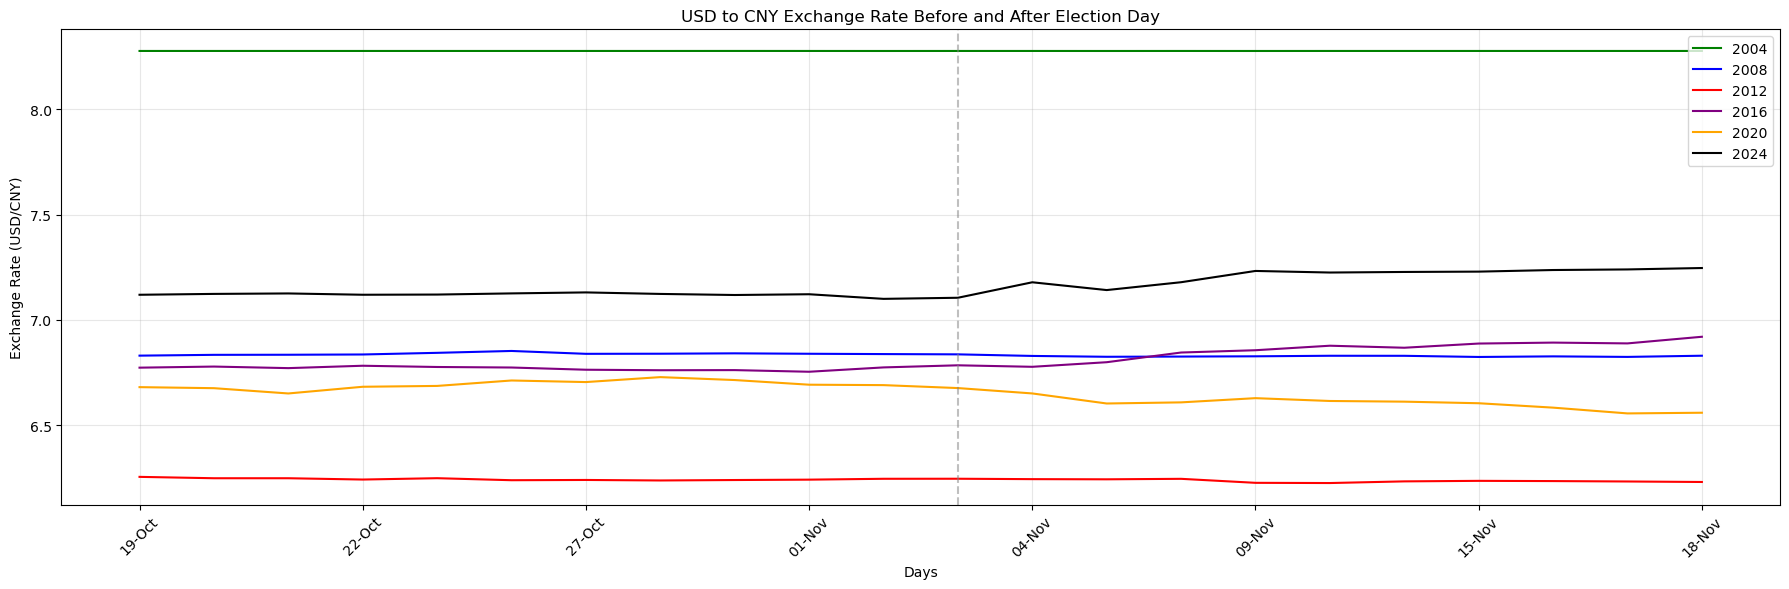

In [59]:
# USE THIS FOR FINAL PLOT
plt.clf()

# Create the figure
plt.figure(figsize=(18, 6))

# Plot each line using the combo dataframes and DayMonth column
plt.plot(range(len(exchange_rates_2004_combo)), exchange_rates_2004_combo['CNY'], label='2004', color='green')
plt.plot(range(len(exchange_rates_2008_combo)), exchange_rates_2008_combo['CNY'], label='2008', color='blue')
plt.plot(range(len(exchange_rates_2012_combo)), exchange_rates_2012_combo['CNY'], label='2012', color='red')
plt.plot(range(len(exchange_rates_2016_combo)), exchange_rates_2016_combo['CNY'], label='2016', color='purple')
plt.plot(range(len(exchange_rates_2020_combo)), exchange_rates_2020_combo['CNY'], label='2020', color='orange')
plt.plot(range(len(exchange_rates_2024_combo)), exchange_rates_2024_combo['CNY'], label='2024', color='black')

# Customize the plot
plt.title('USD to CNY Exchange Rate Before and After Election Day')
plt.xlabel('Days')
plt.ylabel('Exchange Rate (USD/CNY)')

# Use the DayMonth from one of the combo dataframes for x-axis labels
# Show every 3rd label to avoid overcrowding
x_ticks = range(0, len(exchange_rates_2004_combo), 3)
plt.xticks(x_ticks, exchange_rates_2004_combo['DayMonth'].iloc[x_ticks], rotation=45)

# Add vertical line at election day (middle point)
middle_idx = len(exchange_rates_2004_combo) // 2
plt.axvline(x=middle_idx, color='gray', linestyle='--', alpha=0.5)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Add legend
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the chart
plt.show()

# 3. Analyze the Data

<Figure size 640x480 with 0 Axes>

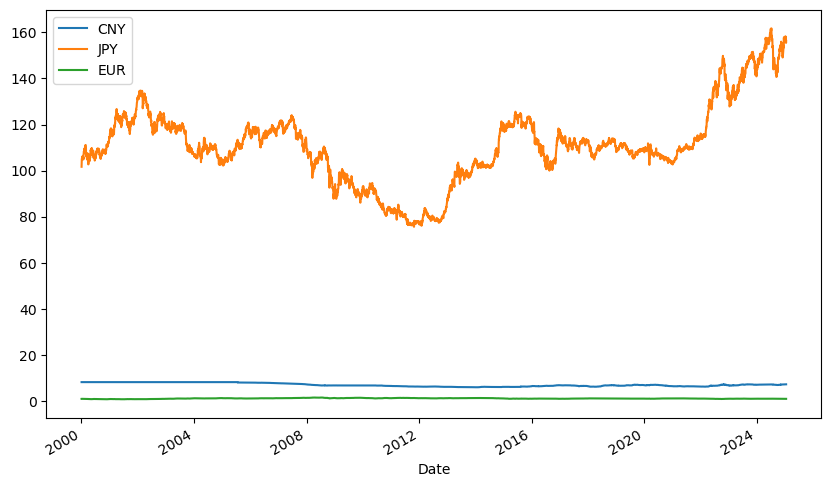

In [60]:
# plot df_currency_rates
plt.clf()
df_currency_rates.plot(figsize=(10,6))
plt.show()

In [76]:
# Create a new column called 'Lagged Currency Rate' for the df df_china_daily
df_china_daily['Lagged Currency Rate'] = df_china_daily['CNY'].shift(1)

# Add a column calculate the percent change with .pct_change()
df_china_daily['Daily Rate Change'] = df_china_daily['CNY'].astype(float).pct_change()
 
# Add a column with the volatility of the exchanges rates on a monthly bases with a rolling window of 4 days using the df df_currency_rates
df_china_daily['Currency Volatiilty'] = df_china_daily['Daily Rate Change'].rolling(window=4).std()




/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_86686/3230458523.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_china_daily['Daily Rate Change'] = df_china_daily['CNY'].astype(float).pct_change()


In [89]:
df_china_daily

,CNY,Lagged Currency Rate,Daily Rate Change,Currency Volatiilty
Date,,,,
3-JAN-00,8.2798,None,NaN,NaN
4-JAN-00,8.2799,8.2798,0.000012,NaN
5-JAN-00,8.2798,8.2799,-0.000012,NaN
6-JAN-00,8.2797,8.2798,-0.000012,NaN
7-JAN-00,8.2794,8.2797,-0.000036,0.000020
...,...,...,...,...
13-JAN-25,7.3319,7.3326,-0.000095,0.000357
14-JAN-25,7.3311,7.3319,-0.000109,0.000099
15-JAN-25,7.3304,7.3311,-0.000095,0.000084


In [92]:
df_china_daily.dtypes

CNY                      object
Lagged Currency Rate     object
Daily Rate Change       float64
Currency Volatiilty     float64
dtype: object

In [96]:
df_china_daily.index = pd.to_datetime(df_china_daily.index)

/var/folders/yg/wczv5tr14310nbkhj3m8dkkh0000gn/T/ipykernel_86686/475300444.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_china_daily.index = pd.to_datetime(df_china_daily.index)


<Figure size 640x480 with 0 Axes>

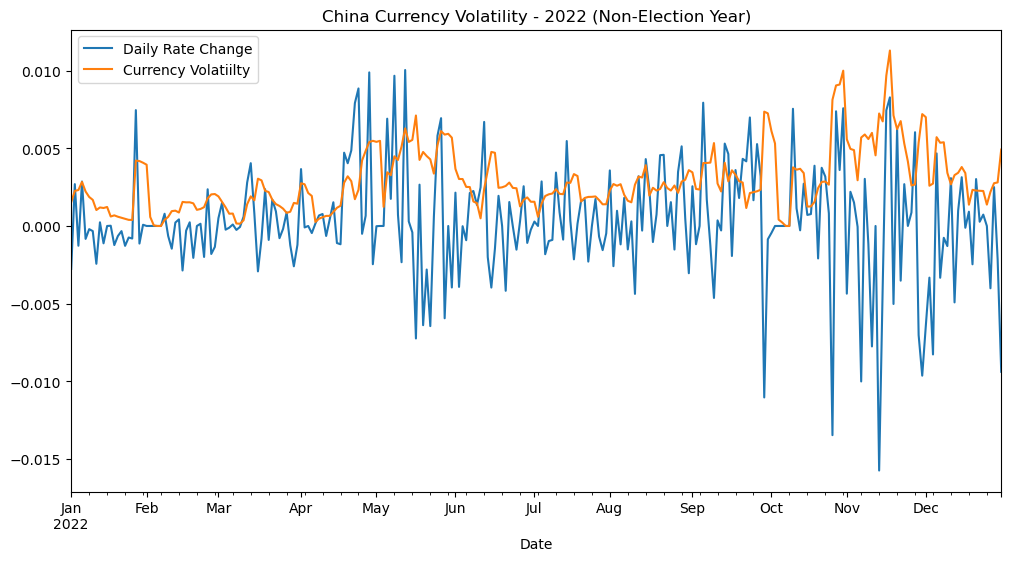

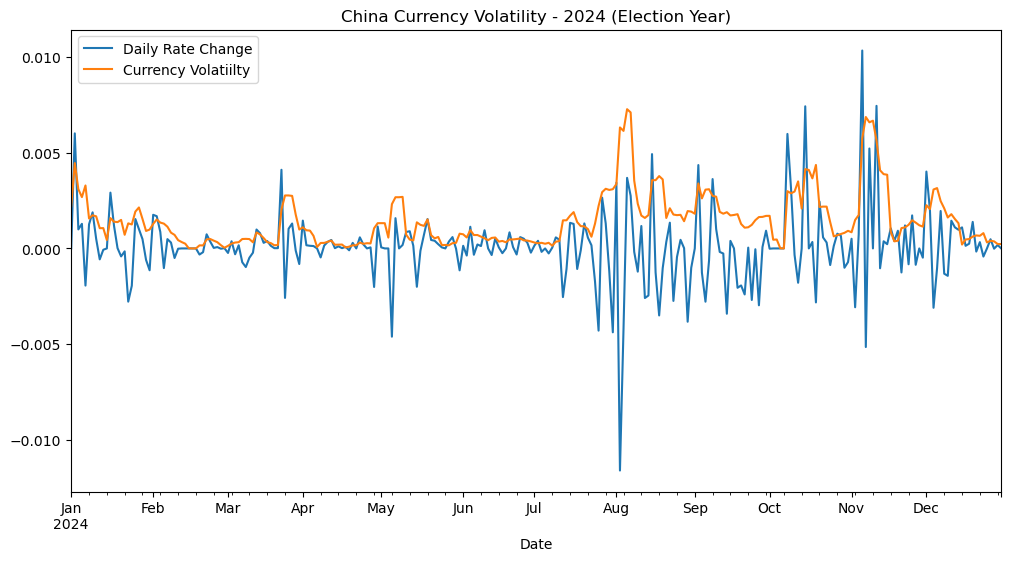

In [109]:
# Visualize the currency volatility
df_china_daily_zoom_2022 = df_china_daily.loc['01-JAN-22':'31-DEC-22']
df_china_daily_zoom_2024 = df_china_daily.loc['01-JAN-24':'31-DEC-24']

# Show the plot
plt.clf()
df_china_daily_zoom_2022.plot(figsize=(12, 6), title="China Currency Volatility - 2022 (Non-Election Year)")
df_china_daily_zoom_2024.plot(figsize=(12, 6), title="China Currency Volatility - 2024 (Election Year)")
plt.show()
